In [1]:
%load_ext autoreload
%autoreload 2

from Project import Project
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
from pyts.image import GramianAngularField, MarkovTransitionField, RecurrencePlot
from Scripts.data import Fields

***

In [20]:
# GENERAL PARAMETERS
signal_length = '1024'
preprocessing = 'cca'
data = pd.read_csv((Project.output_dir/('SSVEPDataset_'+signal_length+'.csv')).__str__(), dtype = 'str')
indexes = list(data.index)
figSize = (12, 12)

***

### Gramian Angular Field Script

#### Description

The original time series $X = \{x_1,\; x_2, \; \ldots, \; x_n\}$ is first normalized between $[-1,\; 1]$ by:

$$
\begin{eqnarray}
    \label{eq:gaf_normalization}
    \tilde{x}_{i} = \dfrac{(x_i - X_{\text{max}}) + (x_i - X_{\text{min}})}{X_{\text{max}} - X_{\text{min}}}
\end{eqnarray}
$$

The rescaled time series $\tilde{X}$ can then be represented in polar coordinates by encoding its values using the angular cosine function and the time stamp $t_i$, which is divided by a constant factor $N$ in order to regularize the span of the coordinate system. 

$$
\begin{eqnarray}
    \label{eq:gaf_polar_transformation}
    \begin{cases}
        \phi_i = \arccos{(\overline{x}_i)}, & -1 \leq \tilde{x}_i \leq 1, \;\; \tilde{x}_i \in \tilde{X} \\
        r_i = \dfrac{t_i}{N}, & t_i \in \mathbb{N}
    \end{cases}
\end{eqnarray}
$$

With this change of coordinates, we build two quasi-Gramian matrices, the Gramian Angular Fields (GAFs): the Gramian Summation Angular Field (GASF) and the Gramian Difference Angular Field (GADF). Both matrices preserve temporal dependency and encode temporal correlations of superposition and difference, the main diagonal corresponding to the original time series. The size of each matrix will be equal to $n \times n$, hence Piecewise Aggregation Approximation (PAA) is applied to short the time series while preserving trends.

$$
\begin{eqnarray}
    \label{eq:gaf_gasf}
    GASF = 			
    \begin{bmatrix}
        \cos(\phi_1 + \phi_1) & \cdots & \cos(\phi_1 + \phi_n) \\
        \cos(\phi_2 + \phi_1) & \cdots &
\cos(\phi_2 + \phi_n) \\
        \vdots & \ddots & \vdots \\
        \cos(\phi_n + \phi_1) & \cdots & \cos(\phi_n + \phi_n) \\
    \end{bmatrix} \\
    GASF = \tilde{X}^{T}\cdot\tilde{X} - \sqrt{I - \tilde{X}^2}^{T}\cdot\sqrt{I - \tilde{X}^2} \\
    GADF = 			
    \begin{bmatrix}
        \sin(\phi_1 - \phi_1) & \cdots & \sin(\phi_1 - \phi_n) \\
        \sin(\phi_2 - \phi_1) & \cdots &
\sin(\phi_2 - \phi_n) \\
        \vdots & \ddots & \vdots \\
        \sin(\phi_n - \phi_1) & \cdots & \sin(\phi_n - \phi_n) \\
    \end{bmatrix} \\
    GADF = \sqrt{I - \tilde{X}^2}^{T} \cdot \tilde{X} - \tilde{X}^{T}\cdot \sqrt{I - \tilde{X}^2}
\end{eqnarray}
$$

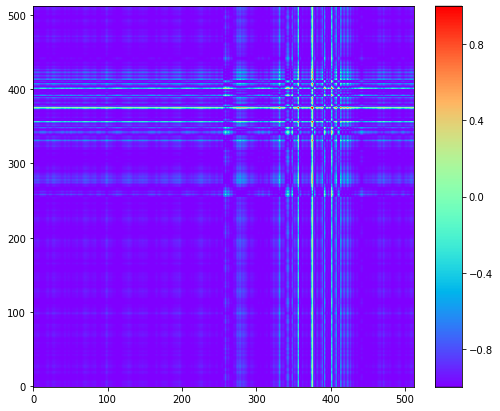

In [23]:
# EXAMPLE: GRAMIAN ANGULAR SUMMATION FIELD
sample = np.loadtxt(data.loc[0]['path']).reshape(1, -1)
gasf = GramianAngularField(image_size = 1., method = 'summation')
X_gasf = gasf.fit_transform(sample)

fig = plt.figure(figsize = (12, 7))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 1),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.3,
                 )

for ax in grid:
    im = ax.imshow(X_gasf[0], cmap = 'rainbow', origin = 'lower')

ax.cax.colorbar(im)
ax.cax.toggle_label(True)
plt.show()

In [7]:
# Summation
gasf = GramianAngularField(image_size = 256, method = 'summation')
method = 'gasf'
fig_path = Project.images_dir / preprocessing / method / signal_length

In [28]:
Fields.createField(gasf, data, indexes, figSize, fig_path, signal_length, preprocessing, Project)

In [29]:
# Difference
gadf = GramianAngularField(image_size = 256, method = 'difference')
method = 'gadf'
fig_path = Project.images_dir / preprocessing / method / signal_length

In [51]:
Fields.createField(gadf, data, indexes, figSize, fig_path, signal_length, preprocessing, Project)

### Markov Transition Field Script

#### Description

Inspired by previous works that try to codify time series into a network structures (citação), the Markov Transition Field (MTF) explores Markov transition probabilities while maintaing information in the time domain. A time series $X = \{x_1,\; x_2, \; \ldots, \; x_n\}$ has its data (magnitude) divided into $Q$ quantile bins and each value $x_i$ is assigned to a corresponding bin $q_j \; (j \in [1, Q])$. The Markov Transition Matrix $W = (w_{i, j})_{Q\times Q}$ is then built, where a value $w_{i, j}$ is given by the frequency with which there is a transition between quantiles $q_i$ and $q_j$, satisfying $\sum_j w_{ij} = 1$. The Markov Transition Field is defined by

$$
\begin{eqnarray}
    M = 
    \begin{bmatrix}
        w_{ij}|_{x_1 \in q_i,\; x_1 \in q_j} & \cdots & w_{ij}|_{x_1 \in q_i, \; x_n \in q_j} \\
        w_{ij}|_{x_2 \in q_i,\; x_1 \in q_j} & \cdots & w_{ij}|_{x_2 \in q_i, \; x_n \in q_j} \\
        \vdots & \ddots & \vdots \\
        w_{ij}|_{x_n \in q_i,\; x_1 \in q_j} & \cdots & w_{ij}|_{x_n \in q_i, \; x_n \in q_j} \\
    \end{bmatrix}
\end{eqnarray}
$$


Each value $M_{ij}$ corresponds to the transition probability $q_i \rightarrow q_j$, where $q_i, q_j \in [1, Q]$ are the quantile bins that contain the data at time stamp $i$ and $j$, respectively. It can be understood as a spreading out of the Markov Transition Matrix $W$, considering temporal relations - $M_{i, j | |i - j| = k}$ denotes the transition probability between points with time interval $k$. The size of the MTF is regulated by the non-overlapping application of a $m \times m $ kernel $\{\dfrac{1}{m^2}\}_{m\times m}$.  

In [ ]:
# EXAMPLE: MARKOV TRANSITION FIELD
sample = np.loadtxt(data.loc[0]['path']).reshape(1, -1)
mtf = MarkovTransitionField(image_size = 1.0)
X_mtf = mtf.fit_transform(sample)

fig = plt.figure(figsize = (12, 7))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 1),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.3,
                 )

for ax in grid:
    im = ax.imshow(X_mtf[0], cmap = 'rainbow', origin = 'lower')

ax.cax.colorbar(im)
ax.cax.toggle_label(True)
plt.show()

In [52]:
mtf = MarkovTransitionField(image_size = 256)
method = 'mtf'
fig_path = Project.images_dir / preprocessing / method / signal_length

In [73]:
indexes = range(2500, 2730)

In [74]:
Fields.createField(mtf, data, indexes, figSize, fig_path, signal_length, preprocessing, Project)

### Recurrence Plot Script

#### Description

The Recurrence Plot is a graphical tool for measuring the time constancy of dynamical systems (citação). Through this diagnostic tool it's possible to infer properties of the underlying system of a time series that otherwise would be difficult to obtain, such as autonomy.

Given a time series $x(1), \ldots, x(n)$, and considering $i \in \{1, \ldots, n-d+1\}$, we choose an embedding dimension $d$, building a d-dimensional orbit $y(i)$ given by

$$
\begin{eqnarray}
    \label{eq:recurr_orbit}
    y(i) = (x(i), x(i+1), \ldots, x(i+d-1)) 
\end{eqnarray}
$$

The plot is built by a set of points $R_{i, j}$ defined by

$$
\begin{eqnarray}
    \label{eq:recurr_plot_eq}
    R_{i, j} = \Theta( \varepsilon_i - ||y(i) - y(j)||)
\end{eqnarray}
$$

where $\Theta(\cdot)$ is the Heaviside function, a stepsize function 1 or 0 if its argument is non-negative or positive, respectively, and $\varepsilon_i$ is a threshold. The threshold needs to be chosen such that a reasonable number of points $y(j)$ lies within its radius centered at $y(i)$, therefore it can depend on $i$.

C:\Users\Patrick\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.


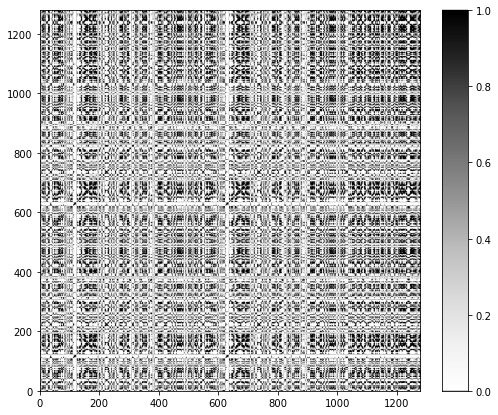

In [12]:
# EXAMPLE: RECURRENCE PLOT
sample = np.loadtxt( (Project.combined_series_dir / preprocessing / signal_length / data.loc[0]['subject'] / data.loc[0]['state'] / data.loc[0]['file']).__str__() ).reshape(1, -1)
mtf = RecurrencePlot(threshold = 'point', percentage = 40)
X_mtf = mtf.fit_transform(sample)

fig = plt.figure(figsize = (12, 7))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 1),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.3,
                 )

for ax in grid:
    im = ax.imshow(X_mtf[0], cmap = 'Greys', origin = 'lower')

ax.cax.colorbar(im)
ax.cax.toggle_label(True)
plt.show()

In [21]:
rp = RecurrencePlot(threshold = 'point', percentage = 40)
method = 'rp'
cmap = 'Greys'
fig_path = Project.images_dir / preprocessing / method / signal_length

In [22]:
len(data)

1352

In [26]:
Fields.createField(rp, data, range(900, 1200), figSize, fig_path, signal_length, preprocessing, Project, cmap = cmap)